In [1]:
import sys


In [2]:
sys.path.append("/home/jovyan/sivtsov/associative-recurrent-memory-transformer")

In [3]:
import json
import logging
import os
import math
import shutil
from pathlib import Path
from itertools import chain

# from dotenv import load_dotenv
import torch
import numpy as np
import datasets
import transformers
from torch.utils.data import DataLoader
from huggingface_hub import hf_hub_download

torch.set_grad_enabled(False)

from transformers import AutoConfig, AutoTokenizer, HfArgumentParser, AutoModelForCausalLM

from modeling_rmt.language_modeling import MemoryCell, RecurrentWrapper
from modeling_amt.language_modeling import AssociativeMemoryCell, AssociativeRecurrentWrapper
from modeling_rmt.lm_parallel_mem import MemoryCell as PMemoryCell, RecurrentWrapper as PRecurrentWrapper

from torch.nn.utils.rnn import pad_sequence

/home/jovyan/.mlspace/envs/svtdanny/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [5]:
# dtype=torch.float32
dtype=torch.bfloat16
torch.set_default_dtype(dtype)

In [6]:
source_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B"
                                             , attn_implementation="sdpa"
                                             ,torch_dtype=dtype)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")

In [7]:
source_grouped_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B"
                                             , attn_implementation="sdpa"
                                             ,torch_dtype=dtype)

In [8]:
# import torch
# source_model.lm_head = torch.nn.Identity()
# source_model.to('cuda')

# # s= [32, 128, 256, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]
# input_ids = torch.randint(0, 10000, (1, 256), dtype=torch.long, device="cuda")

In [9]:
# %%time

# o = source_model.forward(input_ids)

# torch.cuda.synchronize()

In [10]:
# source_model.to('cuda')

In [11]:
# nums_segments = [1024]

# segment_size = 32
segment_size = 1024
block_size = segment_size

# test_size = 1000
# batch_size = 1

# model_name = 'armt'
# num_mem_tokens = 16
num_mem_tokens = 128
model_path = './models'
d_mem = 64

# task_dataset = "qa1_single-supporting-fact"
# max_n_facts = None

In [12]:
mem_cell_cls = AssociativeMemoryCell
rec_wrap_cls = AssociativeRecurrentWrapper

In [13]:
# ls -la /home/jovyan/.cache/huggingface/hub/models--irodkin--ARMT-llama3.2-1B/snapshots/746e74bba3edc4cb3eaa11e13df5d900495e2300/armt_llama3.2-1B_step19500.bin

In [ ]:
mem_cell_args = dict(
        base_model=source_model,
        num_mem_tokens=num_mem_tokens,
)
if d_mem is not None:
    mem_cell_args['d_mem'] = d_mem


cell = mem_cell_cls(**mem_cell_args, wrap_pos=False, layers_attr="model.layers")
armt_model = rec_wrap_cls(cell, segment_size=block_size, k2=-1)

# model_cpt = os.path.join(model_path, "/home/jovyan/.cache/huggingface/hub/models--irodkin--ARMT-llama3.2-1B/snapshots/746e74bba3edc4cb3eaa11e13df5d900495e2300/armt_llama3.2-1B_step19500.bin")
# cpt = torch.load(model_cpt, map_location='cuda')
# armt_model.load_state_dict(cpt, strict=False)
armt_model.eval().to('cuda')




/tmp/ipykernel_2886813/1118790681.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cpt = torch.load(model_cpt, map_location='cuda')


RuntimeError: Error(s) in loading state_dict for AssociativeRecurrentWrapper:
	size mismatch for memory_cell.memory: copying a param with shape torch.Size([16, 2048]) from checkpoint, the shape in current model is torch.Size([128, 2048]).

In [15]:
cell

AssociativeMemoryCell(
  (model): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(128256, 2048)
      (layers): ModuleList(
        (0-15): 16 x AssociativeLayerWrapper(
          (W_mq): Linear(in_features=2048, out_features=64, bias=False)
          (W_mk): Linear(in_features=2048, out_features=64, bias=False)
          (W_mv): Linear(in_features=2048, out_features=2048, bias=False)
          (W_mb): Linear(in_features=2048, out_features=1, bias=True)
          (layer): LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
              (k_proj): Linear(in_features=2048, out_features=512, bias=False)
              (v_proj): Linear(in_features=2048, out_features=512, bias=False)
              (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
              (rotary_emb): LlamaRotaryEmbedding()
            )
            (mlp): LlamaMLP(
              (gate_

In [16]:
mem_cell_args = dict(
        base_model=source_grouped_model,
        num_mem_tokens=num_mem_tokens,
)
if d_mem is not None:
    mem_cell_args['d_mem'] = d_mem


cell = mem_cell_cls(**mem_cell_args, wrap_pos=False, layers_attr="model.layers")
armt_grouped_model = rec_wrap_cls(cell, segment_size=block_size, k2=-1)

# model_cpt = os.path.join(model_path, "/home/jovyan/.cache/huggingface/hub/models--irodkin--ARMT-llama3.2-1B/snapshots/746e74bba3edc4cb3eaa11e13df5d900495e2300/armt_llama3.2-1B_step19500.bin")
# cpt = torch.load(model_cpt, map_location='cuda')
# armt_grouped_model.load_state_dict(cpt, strict=False)
armt_grouped_model.eval().to('cuda')




AssociativeRecurrentWrapper(
  (memory_cell): AssociativeMemoryCell(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x AssociativeLayerWrapper(
            (W_mq): Linear(in_features=2048, out_features=64, bias=False)
            (W_mk): Linear(in_features=2048, out_features=64, bias=False)
            (W_mv): Linear(in_features=2048, out_features=2048, bias=False)
            (W_mb): Linear(in_features=2048, out_features=1, bias=True)
            (layer): LlamaDecoderLayer(
              (self_attn): LlamaSdpaAttention(
                (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
                (k_proj): Linear(in_features=2048, out_features=512, bias=False)
                (v_proj): Linear(in_features=2048, out_features=512, bias=False)
                (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
                (rotary_emb): LlamaRot

In [17]:
for i in range(len(armt_model.memory_cell.model.model.layers)):
    armt_model.memory_cell.model.model.layers[i].W_mem = armt_model.memory_cell.model.model.layers[i].W_mem.to('cuda')
    armt_grouped_model.memory_cell.model.model.layers[i].W_mem = armt_grouped_model.memory_cell.model.model.layers[i].W_mem.to('cuda')
    
    armt_model.memory_cell.model.model.layers[i].z = armt_model.memory_cell.model.model.layers[i].z.to('cuda')
    armt_grouped_model.memory_cell.model.model.layers[i].z = armt_grouped_model.memory_cell.model.model.layers[i].z.to('cuda')

In [18]:
armt_model.memory_cell.model.model.layers[0].W_mem.device

device(type='cuda', index=0)

In [19]:
# just to not catch oom on large context
# source_model.lm_head = torch.nn.Linear(source_model.lm_head.in_features, 10000, bias=False)
# source_grouped_model.lm_head = torch.nn.Linear(source_grouped_model.lm_head.in_features, 10000, bias=False)
# armt_model_dualed.memory_cell.model.lm_head = source_model.lm_head.to('cuda')
# armt_grouped_model.memory_cell.model.lm_head = source_grouped_model.lm_head.to('cuda')

source_model.lm_head = torch.nn.Identity()
source_grouped_model.lm_head = torch.nn.Identity()
armt_model.memory_cell.model.lm_head = torch.nn.Identity()
armt_grouped_model.memory_cell.model.lm_head = torch.nn.Identity()

In [20]:
# source_model.eval().to('cuda')

In [21]:
def group_gemm_naive(As, Bs):
    return [A @ B for A, B in zip(As, Bs)]

def get_naive_grouped_forward(Ws, bias=None):
    def forward(Xs):
        res_list = group_gemm_naive(Xs.unbind(0), Ws)
        res = torch.stack(res_list)
        # print(f"Outs: {res.shape}")
        if bias is not None:
            res += bias
        return res
    return forward
    


# import cutlass
# def group_gemm_jit(As, Bs):
#     dtype = As[0].dtype
#     plan = cutlass.op.GroupedGemm(element=dtype, element_accumulator=torch.float32, layout=cutlass.LayoutType.RowMajor)

#     Cs = [torch.zeros(a.shape[:-1] + (b.shape[-1],), dtype=a.dtype, device=a.device) for a,b in zip(As, Bs)]
#     Ds = [torch.zeros_like(el) for el in Cs]
    
#     plan.run(As, Bs, Cs, Ds, print_module=True)
#     op = plan.construct()
#     grouped_gemm = cutlass.emit.pytorch(op, name='grouped_gemm', cc=plan.cc, sourcedir='out', jit=True)

#     return grouped_gemm

import cutlass

USE_EFFICIENT_ALLOCATION = True

sys.path.append("/home/jovyan/sivtsov/armt")
# import cutlass_emit_pytorch_mocked

def group_gemm_jit(As, Bs):
    dtype = As[0].dtype
    plan = cutlass.op.GroupedGemm(element=dtype, element_accumulator=torch.float32, layout=cutlass.LayoutType.RowMajor)

    Cs = [torch.zeros(a.shape[:-1] + (b.shape[-1],), dtype=a.dtype, device=a.device) for a,b in zip(As, Bs)]
    Ds = [torch.zeros_like(el) for el in Cs]
    
    plan.run(As, Bs, Cs, Ds, print_module=True)
    op = plan.construct()

    if USE_EFFICIENT_ALLOCATION:
        print("USE_EFFICIENT_ALLOCATION")
        import cutlass_emit_pytorch_mocked
        grouped_gemm = cutlass_emit_pytorch_mocked.pytorch(op, name='grouped_gemm', cc=plan.cc, sourcedir='out', jit=True)
    else:
        grouped_gemm = cutlass.emit.pytorch(op, name='grouped_gemm', cc=plan.cc, sourcedir='out', jit=True)

    return grouped_gemm

def get_group_gemm():
    gemm_fn = None
    
    def group_gemm(As, Bs):
        nonlocal gemm_fn
        if gemm_fn is None:
            print(f"jit compile As: {[a.shape for a in As]} Bs: {[b.shape for b in Bs]}")
            gemm_fn = group_gemm_jit(As, Bs)

        return gemm_fn.run(As, Bs)

    return group_gemm




In [22]:
armt_grouped_model.memory_cell.model.model.layers

ModuleList(
  (0-15): 16 x AssociativeLayerWrapper(
    (W_mq): Linear(in_features=2048, out_features=64, bias=False)
    (W_mk): Linear(in_features=2048, out_features=64, bias=False)
    (W_mv): Linear(in_features=2048, out_features=2048, bias=False)
    (W_mb): Linear(in_features=2048, out_features=1, bias=True)
    (layer): LlamaDecoderLayer(
      (self_attn): LlamaSdpaAttention(
        (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
        (k_proj): Linear(in_features=2048, out_features=512, bias=False)
        (v_proj): Linear(in_features=2048, out_features=512, bias=False)
        (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        (rotary_emb): LlamaRotaryEmbedding()
      )
      (mlp): LlamaMLP(
        (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
        (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
        (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
        (act_f

In [23]:
W_mq_group = [l.W_mq.weight.data.T.contiguous() for l in armt_model.memory_cell.model.model.layers]
W_mk_group = [l.W_mk.weight.data.T.contiguous() for l in armt_model.memory_cell.model.model.layers]
W_mv_group = [l.W_mv.weight.data.T.contiguous() for l in armt_model.memory_cell.model.model.layers]
W_mb_group = [l.W_mb.weight.data.T.contiguous() for l in armt_model.memory_cell.model.model.layers]

W_mem_group = [l.W_mem.data.contiguous() for l in armt_model.memory_cell.model.model.layers]
z_group = [l.z.data.contiguous() for l in armt_model.memory_cell.model.model.layers]

q_proj_group = [l.layer.self_attn.q_proj.weight.data.T.contiguous() for l in armt_model.memory_cell.model.model.layers]
k_proj_group = [l.layer.self_attn.k_proj.weight.data.T.contiguous() for l in armt_model.memory_cell.model.model.layers]
v_proj_group = [l.layer.self_attn.v_proj.weight.data.T.contiguous() for l in armt_model.memory_cell.model.model.layers]
o_proj_group = [l.layer.self_attn.o_proj.weight.data.T.contiguous() for l in armt_model.memory_cell.model.model.layers]

gate_proj_group = [l.layer.mlp.gate_proj.weight.data.T.contiguous() for l in armt_model.memory_cell.model.model.layers]
up_proj_group = [l.layer.mlp.up_proj.weight.data.T.contiguous() for l in armt_model.memory_cell.model.model.layers]
down_proj_group = [l.layer.mlp.down_proj.weight.data.T.contiguous() for l in armt_model.memory_cell.model.model.layers]

input_layernorm_group = [l.layer.input_layernorm.weight.data for l in armt_model.memory_cell.model.model.layers]
post_attention_layernorm_group = [l.layer.post_attention_layernorm.weight.data for l in armt_model.memory_cell.model.model.layers]

input_layernorm_group = torch.stack(input_layernorm_group).contiguous()
post_attention_layernorm_group = torch.stack(post_attention_layernorm_group).contiguous()




In [24]:
def get_grouped_gemm_forward(Ws, bias=None):
    gemm_fn = get_group_gemm()
    
    def forward(Xs):
        nonlocal gemm_fn
        # print(f"Xs: {Xs.shape}, Ws[0]: {Ws[0].shape}")
        Xs = Xs.contiguous()
        res_list = gemm_fn(Xs.unbind(0), Ws)
        # res_list = group_gemm_naive(Xs.unbind(0), Ws)
        if isinstance(res_list, list):
            res = torch.stack(res_list).contiguous()
        else:
            res = res_list  
        # print(f"Outs: {res.shape}")
        if bias is not None:
            res += bias
        return res
    return forward

In [25]:
grouped_model_layer = armt_grouped_model.memory_cell.model.model.layers[0]



In [26]:
grouped_model_layer.W_mb

Linear(in_features=2048, out_features=1, bias=True)

In [27]:
grouped_model_layer.W_mq.forward = get_grouped_gemm_forward(W_mq_group)
grouped_model_layer.W_mk.forward = get_grouped_gemm_forward(W_mk_group)
grouped_model_layer.W_mv.forward = get_grouped_gemm_forward(W_mv_group)
grouped_model_layer.W_mb.forward = get_naive_grouped_forward(W_mb_group)

grouped_model_layer.W_mem.data = torch.concat(W_mem_group, dim=0)
grouped_model_layer.z.data = torch.concat(z_group, dim=0)

grouped_model_layer.layer.self_attn.q_proj.forward = get_grouped_gemm_forward(q_proj_group)
grouped_model_layer.layer.self_attn.k_proj.forward = get_grouped_gemm_forward(k_proj_group)
grouped_model_layer.layer.self_attn.v_proj.forward = get_grouped_gemm_forward(v_proj_group)
grouped_model_layer.layer.self_attn.o_proj.forward = get_grouped_gemm_forward(o_proj_group)


grouped_model_layer.layer.mlp.gate_proj.forward = get_grouped_gemm_forward(gate_proj_group)
grouped_model_layer.layer.mlp.up_proj.forward = get_grouped_gemm_forward(up_proj_group)
grouped_model_layer.layer.mlp.down_proj.forward = get_grouped_gemm_forward(down_proj_group)


grouped_model_layer.layer.input_layernorm.weight.data = input_layernorm_group[:, None, :]
grouped_model_layer.layer.post_attention_layernorm.weight.data = post_attention_layernorm_group[:, None, :]

In [28]:
grouped_model_layer.W_mem.shape

torch.Size([16, 384, 2048])

In [29]:
# grouped_model_layer.W_mem.data = torch.rand_like(grouped_model_layer.W_mem.data)
# grouped_model_layer.z.data = torch.rand_like(grouped_model_layer.z.data)

# grouped_model_layer.W_mem.data = torch.zeros_like(grouped_model_layer.W_mem.data)
# grouped_model_layer.z.data = torch.zeros_like(grouped_model_layer.z.data)

In [30]:
# layer_inp = torch.rand((len(source_model.model.layers), 48, 2048), dtype=dtype, device="cuda").contiguous()

In [31]:
# layer_inp.shape, layer_inp[:, :, 0].shape

In [32]:
l_id = 10

In [33]:
# layer_inp = torch.zeros_like(layer_inp)
# layer_inp[0] = armt_model.memory_cell.model.model.layers[0]._last_input

In [34]:
# last_kwargs = armt_model.memory_cell.model.model.layers[0]._last_kwargs

In [35]:
l_id = 0

In [36]:
%%time
# armt_model.memory_cell.zero_mem()
# armt_model.memory_cell.model.model.layers[l_id].W_mem.data = grouped_model_layer.W_mem.data[l_id:l_id+1].clone()
# armt_model.memory_cell.model.model.layers[l_id].z.data = grouped_model_layer.z.data[l_id:l_id+1].clone()
# o0 = armt_model.memory_cell.model.model.layers[l_id](
#     layer_inp, position_ids=layer_inp[:, :, 0]
# )
# o0 = armt_model.memory_cell.model.model.layers[l_id](
#     layer_inp, **last_kwargs
# )
# o0 = armt_model.memory_cell.model.model.layers[l_id].associate(
#     layer_inp
# )

torch.cuda.synchronize()

CPU times: user 105 μs, sys: 7 μs, total: 112 μs
Wall time: 109 μs


In [37]:
%%time
# armt_grouped_model.memory_cell.zero_mem()
# o1 = grouped_model_layer.forward(
#     layer_inp, position_ids=layer_inp[:, :, 0]
# )
# o1 = grouped_model_layer.forward(
#     layer_inp, **last_kwargs
# )

# o1 = grouped_model_layer.associate(
#     layer_inp
# )


torch.cuda.synchronize()

CPU times: user 96 μs, sys: 6 μs, total: 102 μs
Wall time: 103 μs


In [38]:
# o0[0].shape, o1[0].shape

In [39]:
# o0[l_id] - o1[l_id], torch.norm(o0[l_id] - o1[l_id])/torch.norm(o0[l_id])

In [40]:
# o0[0][l_id] - o1[0][l_id], torch.norm(o0[0][l_id] - o1[0][l_id])/torch.norm(o0[0][l_id])

In [41]:
# o0[l_id]

In [42]:
# o1[l_id]

In [43]:
# source_model.get_input_embeddings().weight.data.std()

In [44]:
armt_grouped_model_layers = armt_grouped_model.memory_cell.model.model.layers
armt_grouped_model.out_norm = armt_grouped_model.memory_cell.model.model.norm
armt_grouped_model.memory_cell.model.model.norm = torch.nn.Identity()

In [45]:
armt_grouped_model.memory_cell.model.model.layers = torch.nn.ModuleList(
    [grouped_model_layer]
)


In [46]:
# seg_kwargs = armt_grouped_model.memory_cell.process_input(torch.tensor([[1,2,3,4]], device="cuda", dtype=torch.long))

In [47]:
# hid_inp = seg_kwargs['inputs_embeds']

In [48]:
# armt_grouped_model.memory_cell.model.model.forward([1,2,3,4])

In [49]:
armt_grouped_model

AssociativeRecurrentWrapper(
  (memory_cell): AssociativeMemoryCell(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0): AssociativeLayerWrapper(
            (W_mq): Linear(in_features=2048, out_features=64, bias=False)
            (W_mk): Linear(in_features=2048, out_features=64, bias=False)
            (W_mv): Linear(in_features=2048, out_features=2048, bias=False)
            (W_mb): Linear(in_features=2048, out_features=1, bias=True)
            (layer): LlamaDecoderLayer(
              (self_attn): LlamaSdpaAttention(
                (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
                (k_proj): Linear(in_features=2048, out_features=512, bias=False)
                (v_proj): Linear(in_features=2048, out_features=512, bias=False)
                (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
                (rotary_emb): LlamaRotaryEmbed

In [50]:
armt_model

AssociativeRecurrentWrapper(
  (memory_cell): AssociativeMemoryCell(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x AssociativeLayerWrapper(
            (W_mq): Linear(in_features=2048, out_features=64, bias=False)
            (W_mk): Linear(in_features=2048, out_features=64, bias=False)
            (W_mv): Linear(in_features=2048, out_features=2048, bias=False)
            (W_mb): Linear(in_features=2048, out_features=1, bias=True)
            (layer): LlamaDecoderLayer(
              (self_attn): LlamaSdpaAttention(
                (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
                (k_proj): Linear(in_features=2048, out_features=512, bias=False)
                (v_proj): Linear(in_features=2048, out_features=512, bias=False)
                (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
                (rotary_emb): LlamaRot

## With batcher

In [51]:
# from grouped_impl import GroupedBatcher


class GroupedBatcher:
    def __init__(self, armt_model, n_layers, seg_size, hid_dim, pos_embed_dim):
        self.armt_model = armt_model
        self.segment_storage = []
        self.n_layers = n_layers
        self.seg_size = seg_size
        self.hid_dim = hid_dim
        self.pos_embed_dim = pos_embed_dim
        self.cur_cont = 0

        self.out_storage = {}
        
    def init_batch(self, dtype=torch.bfloat16, device="cpu"):
        batch = torch.zeros((self.n_layers, self.seg_size, self.hid_dim), dtype=dtype, device=device)
        # batch = torch.zeros((self.n_layers, self.seg_size), dtype=dtype, device=device)
        segments_info = torch.full((self.n_layers,), -1, dtype=torch.int32, device=device)
        # position_ids = torch.full((self.n_layers, self.seg_size), 0, dtype=torch.int32, device=device)
        # positional_embeddings = (torch.zeros((self.n_layers, self.seg_size, self.pos_embed_dim), dtype=dtype, device=device),
        #                         torch.zeros((self.n_layers, self.seg_size, self.pos_embed_dim), dtype=dtype, device=device))
        
        position_ids, positional_embeddings = None, None
        
        return batch, segments_info, position_ids, positional_embeddings
        
    def push(self, batch):
        self.segment_storage.append(
            [
            self.cur_cont,
            batch
            ]
        )
        segm_id = self.cur_cont
        self.cur_cont += 1

        return segm_id
        
    def next(self, batch, segments_info, position_ids, positional_embeddings):     
        batch = torch.roll(batch, 1, 0)
        prev_segments_info = segments_info
        segments_info = torch.roll(segments_info, 1, 0)
        # position_ids = torch.roll(position_ids, 1, 0)
        # positional_embeddings = (torch.roll(positional_embeddings[0], 1, 0), torch.roll(positional_embeddings[1], 1, 0))
        
        if not self.segment_storage:
            batch[0] = 0
            segments_info[0] = -1
            # position_ids[0] = 0
            # positional_embeddings[0][0] = 0
            # positional_embeddings[1][0] = 0
            need_to_zero_mem = prev_segments_info != segments_info
            return batch, segments_info, position_ids, positional_embeddings, need_to_zero_mem
        
        segments_info[0] = self.segment_storage[0][0]
        need_to_zero_mem = prev_segments_info != segments_info
        
        processed_input = self.armt_model.memory_cell.process_input(**self.segment_storage[0][1][0])
        batch[0] = processed_input["inputs_embeds"]

        self.segment_storage[0][1] = self.segment_storage[0][1][1:]
        
        if len(self.segment_storage[0][1]) == 0:
            self.segment_storage = self.segment_storage[1:]
        
        return batch, segments_info, position_ids, positional_embeddings, need_to_zero_mem
    
    def push_out(self, batch_out, segments_info):
        # print("push out segments_info", segments_info)        
        last_segm_info = segments_info[-1].item()
        if last_segm_info != -1:
            batch_out = self.armt_model.memory_cell.process_output(
                    batch_out
                    , None, None
            )
            
            if last_segm_info not in self.out_storage:
                self.out_storage[last_segm_info] = []

            # self.out_storage[last_segm_info].append(batch_out[-1:])
            self.out_storage[last_segm_info].append(batch_out)
            
            
    def get_context_output(self, segm_id):
        segm_out = self.out_storage[segm_id]
        del self.out_storage[segm_id]
        return segm_out
    

In [52]:
import torch.nn as nn
class ArmtGroupedExecutor(nn.Module):
    def __init__(self, armt_model, grouped_model_layer, batcher):
        super().__init__()
        self.armt_model = armt_model
        self.grouped_model_layer = grouped_model_layer
        self.batcher = batcher
        
    def forward(self, input_ids):
        segmented_input = armt_model.segment(
            input_ids=input_ids,
        )

        # processed_segments = [armt_model.memory_cell.process_input(**s_i) for s_i in segmented_input]
        processed_segments = segmented_input
        out_seg_id = self.batcher.push(processed_segments)
        
        batch, segments_info, batch_position_ids, batch_position_embeddings = self.batcher.init_batch(
            # dtype=processed_segments[0]['inputs_embeds'].dtype, device=processed_segments[0]['inputs_embeds'].device
            dtype=torch.get_default_dtype(), device="cuda"
        )
        
        is_first = True

        while is_first or (segments_info != -1).any():
            assert batch is not None
            
            if is_first:
                is_first = False
            
            batch, segments_info, batch_position_ids, batch_position_embeddings, need_to_zero_mem = self.batcher.next(
                batch, segments_info, batch_position_ids, batch_position_embeddings
            )
            if (segments_info == -1).all():
                break
            
            # print("batch = ", batch)
            
            self.armt_model._first_seg_mask = need_to_zero_mem
            
            # need_to_zero_mem = need_to_zero_mem.to('cuda')

            self.grouped_model_layer.first_seg = False
            # for i in range(self.grouped_model_layer.W_mem.data.shape[0]):
            #     if need_to_zero_mem[i].item():
            #         # print("ZEROING MEM: ", i)
            #         self.grouped_model_layer.W_mem.data[i].fill_(0)
            #         self.grouped_model_layer.z.data[i].fill_(0)
            #         # layer.zero_mem()
            self.grouped_model_layer.W_mem.data[need_to_zero_mem].fill_(0)
            self.grouped_model_layer.z.data[need_to_zero_mem].fill_(0)
            
            assoc_batch = self.grouped_model_layer.associate(batch)
            # for i in range(self.grouped_model_layer.W_mem.data.shape[0]):
            #     if not need_to_zero_mem[i].item():
            #         batch[i] += assoc_batch[i]
            batch[~need_to_zero_mem] += assoc_batch[~need_to_zero_mem]
            
            # out = self.armt_model.memory_cell.model(inputs_embeds=batch)
            out = self.armt_model.memory_cell.model.model(inputs_embeds=batch, use_cache=False)
            
            
            # print("LAYER LAST: ", self.armt_model.memory_cell.model.model.layers[0]._last_input)
            # print("LAYER LAST: ", out[0])
            if segments_info[-1].item() != -1:
                out_normed = self.armt_model.out_norm(out[0][-1:])
                lmhead_out = self.armt_model.memory_cell.model.lm_head(out_normed)
                # print("LMHEAD: ",lmhead_out)
                out_logits = transformers.modeling_outputs.CausalLMOutputWithPast(
                    logits=lmhead_out,
                )
            else:
                out_logits = None
            # print("CMP: ",batch.shape, out[0].shape, batch.dtype, out[0].dtype, batch, out[0])
            batch = out[0]
            # self.batcher.push_out(out.logits[-1:], segments_info)
            self.batcher.push_out(out_logits, segments_info)
            
        segm_out_logits = self.batcher.get_context_output(out_seg_id)
        # segm_outs = [transformers.modeling_outputs.CausalLMOutputWithPast(
        #     logits=sol
        # ) for sol in segm_out_logits]
        # segm_outs = segm_out_logits
        
        # out = []
        # for sol in segm_outs:
        #     # out.append(self.armt_model.memory_cell.process_output(sol, None, None))
        #     out.append(sol)
        # out = self.armt_model.process_outputs(out)
        
        out = transformers.modeling_outputs.CausalLMOutputWithPast(
            logits=torch.cat([sol.logits for sol in segm_out_logits], dim=1),
        )
            
        return out

In [53]:
# armt_model.memory_cell.generate_mode(True)
# armt_grouped_model.memory_cell.generate_mode(True)

armt_model.memory_cell.generate_mode(False)
armt_grouped_model.memory_cell.generate_mode(False)

armt_grouped_model._grouped_execution = True
armt_grouped_model._skip_associating = True

armt_model.eval()
armt_grouped_model.eval()
;

''

In [54]:
batcher = GroupedBatcher(
    armt_model=armt_grouped_model,
    n_layers=len(armt_model.memory_cell.model.model.layers), seg_size=segment_size+num_mem_tokens, hid_dim=2048, pos_embed_dim=2048
)
ge = ArmtGroupedExecutor(armt_grouped_model, grouped_model_layer, batcher)

In [55]:
not_random_text = '''
Tom and Lily were twins who liked to play together. They had many toys, but their favorite was a big puzzle with many pieces. They liked to unite the pieces and make a picture of a farm with animals and plants.

One day, their mom and dad said they were going to visit their aunt and uncle, who lived far away. They said they would bring them a gift when they came back. Tom and Lily were excited and wondered what the gift would be.

They packed their bags and got in the car. They drove for a long time, and Tom and Lily got bored. They asked their mom and dad when they would arrive, but they said it was still far. They said they could sing songs or play games to pass the time.

Tom and Lily tried to sing songs, but they did not know many. They tried to play games, but they could not agree on the rules. They started to argue and fight. They pulled each other's hair and kicked each other's legs. They made a lot of noise and made their mom and dad angry.

"Stop it, you two!" their dad said. "You are being very naughty and rude. You should be nice to each other and share your toys. You are twins, you should unite, not fight."

"But he started it!" Tom said.

"No, she started it!" Lily said.

Their mom sighed and said, "It does not matter who started it. You should end it. You are making us very tired and sad. We want to have a good time with your aunt and uncle, not a bad time. They are very kind and fun. They have a big house with a garden and a swing. They also have a dog and a cat. You will like them a lot."

Tom and Lily looked at each other and felt sorry. They did not want to make their mom and dad tired and sad. They did not want to miss the fun with their aunt and uncle. They did not want to fight anymore. They said they were sorry and hugged each other.

Their mom and dad smiled and said, "That's better. We are glad you are friends again. We love you very much. Now, let's have some snacks and enjoy the ride. We are almost there."

They gave them some cookies and juice and turned on the radio. They sang along to the songs and laughed at the jokes. They had a good time and forgot their fight.

When they arrived at their aunt and uncle's house, they were welcomed with hugs and kisses. They saw the big house, the garden, the swing, the dog and the cat. They were amazed and happy. They ran to play with the animals and explore the place.

Their aunt and uncle said they had a surprise for them. They brought them a big box wrapped in colorful paper. They said it was their gift. Tom and Lily opened it and gasped. It was a new puzzle, bigger and more beautiful than their old one. It had many pieces and made a picture of a castle with knights and princesses.

They thanked their aunt and uncle and hugged them. They said they loved the puzzle and wanted to unite it right away. They asked their mom and dad if they could help them. They said yes and joined them on the floor.

They had a lot of fun uniting the puzzle and making the picture. They worked together and helped each other. They were proud of their work and showed it to their aunt and uncle. They said it was very nice and praised them.

They said they had another surprise for them. They said they had made a delicious dinner and invited them to the table. They said they had cooked their favorite food and baked a cake. They also said they had a special drink for their mom and dad. They said it was called wine and it was made from grapes. They said it was for grown-ups only and it made them happy and relaxed.

They went to the table and ate the food and the cake. They said it was very yummy and thanked their aunt and uncle. They saw their mom and dad drink the wine and smile and talk. They said they were very happy and relaxed too.

They said they had one more surprise for them. They said they had prepared a cozy room for them to sleep. They said they had a big bed and soft pillows and blankets. They said they had a night light and a story book. They said they would read them a story and tuck them in.

They went to the room and saw the bed and the pillows and the blankets. They said it was very cozy and thanked their aunt and uncle. They got in the bed and listened to the story. They said it was very interesting and asked for another one. They said they were not sleepy yet.

Their aunt and uncle said they had read enough stories and it was time to sleep. They said they had to wake up early and go back home. They
'''

In [56]:
input_ids = tokenizer.encode(not_random_text, return_tensors="pt").to("cuda")

In [94]:
# seq_len = 10*2*256//32*32
# seq_len = 2*256//32*32

seq_len = 32*1024*4//16
# seq_len = 4096*4
# seq_len = input_ids.shape[1]//32*32

input_ids=torch.randint(0, 10000, (1, seq_len), dtype=torch.long, device="cuda")
# input_ids = input_ids[:, :seq_len]

# segmented_input = armt_model.segment(
#     input_ids=input_ids,
#     # other can be None
# )

In [95]:
seq_len

8192

In [96]:
# len(segmented_input), seq_len/len(segmented_input)

In [97]:
grouped_model_layer.W_mem.shape

torch.Size([16, 384, 2048])

In [98]:
# del ge
# del o0
# del o1
# del batcher
torch.cuda.empty_cache()


In [99]:
%%timeit
armt_model.eval()
with torch.no_grad():
    o0 = ge.forward(input_ids)
    
torch.cuda.synchronize()

595 ms ± 313 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [100]:
%%timeit
with torch.no_grad():
    armt_model.memory_cell.zero_mem()
    o1 = armt_model.forward(input_ids)

torch.cuda.synchronize()

519 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [280]:
# grouped_model_layer.W_mem.data, grouped_model_layer.z.data

In [281]:
# grouped_model_layer._last_input

In [282]:
# armt_grouped_model.memory_cell.model.model.layers[0]._last_input

In [283]:
# armt_model.memory_cell.model.model.layers[0]._last_associate

In [284]:
o0.logits

tensor([[[-0.0148, -0.0510,  1.5078,  ...,  0.5312, -0.4727,  0.2715],
         [-0.1309,  4.3125,  2.4219,  ..., -2.4531, -4.0312,  0.5938],
         [-0.9219,  1.9531,  2.6406,  ...,  0.5117, -3.2188,  0.0776],
         ...,
         [-1.1172,  3.6875,  0.0400,  ..., -1.7422, -1.8125, -0.5312],
         [-0.6406,  3.4688,  2.2188,  ..., -2.5000, -2.1406,  0.7773],
         [-0.2949,  4.1250,  2.0312,  ..., -1.9844, -2.3281,  0.4785]]],
       device='cuda:0')

In [285]:
o1.logits

tensor([[[-0.0189, -0.0503,  1.5000,  ...,  0.5234, -0.4668,  0.2695],
         [-0.1416,  4.3438,  2.4688,  ..., -2.4219, -4.0312,  0.5938],
         [-0.7188,  1.4766,  2.8438,  ...,  0.4785, -3.6406, -0.2969],
         ...,
         [-1.1172,  3.6719,  0.0203,  ..., -1.7500, -1.8125, -0.5391],
         [-0.6328,  3.4531,  2.2344,  ..., -2.5000, -2.1406,  0.7812],
         [-0.3008,  4.0938,  2.0469,  ..., -2.0156, -2.3281,  0.4395]]],
       device='cuda:0', dtype=torch.float32)

In [198]:
compare_first = 1000
torch.norm(o1.logits[0, :compare_first] - o0.logits[0, :compare_first])/torch.norm(o1.logits[0, :compare_first])

tensor(1.1928, device='cuda:0', dtype=torch.float32)

In [67]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        profile_memory=True, record_shapes=True) as prof:
            armt_model.eval()
            with torch.no_grad():
                o0 = ge.forward(input_ids)

In [79]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls                                              Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------  
                                             aten::roll       

In [68]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls                                                                      Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------------------------------------------------------------------

In [69]:
prof.export_chrome_trace("/home/jovyan/sivtsov/armt/armt_from_checkpoint/llama1b_armt_diag_optimized_seg512_mem128_v2.json")

In [64]:
o0

CausalLMOutputWithPast(loss=None, logits=tensor([[[ 2.6875, -1.5703, -0.6055,  ..., -0.4746, -1.8125, -0.4941],
         [ 1.1094,  0.8906, -0.2324,  ..., -0.9141,  0.1299, -0.6289],
         [-0.1084,  0.7695, -1.0078,  ..., -0.3359, -0.2227, -0.1016],
         ...,
         [-1.9922, -0.4980,  0.1348,  ...,  1.0859, -0.7422, -1.3594],
         [-1.9688, -0.1816, -0.4180,  ...,  1.6797, -0.1133, -1.6484],
         [-2.4062, -0.4180, -0.0869,  ...,  1.1016, -0.4785, -1.7031]]],
       device='cuda:0', dtype=torch.float32), past_key_values=None, hidden_states=None, attentions=None)

In [129]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  26041 MiB |  76051 MiB |  33179 GiB |  33154 GiB |
|       from large pool |  25968 MiB |  75955 MiB |  29813 GiB |  29788 GiB |
|       from small pool |     72 MiB |   5144 MiB |   3365 GiB |   3365 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  26041 MiB |  76051 MiB |  33179 GiB |  33154 GiB |
|       from large pool |  25968 MiB |  75955 MiB |  29813 GiB |

In [141]:
t = torch.rand((16, 48, 2048)).cuda()

In [142]:
t.data_ptr()

140191360614400

In [143]:
t.roll(1, 0).data_ptr()

140191371440128

In [152]:
%%time
t = t.roll(1, 0)

CPU times: user 577 μs, sys: 23 μs, total: 600 μs
Wall time: 395 μs


In [173]:
def roll_tensor(t):
    for i in range(1, t.shape[0]):
        t[i] = t[i-1]
        
roll_tensor_jit = torch.jit.script(roll_tensor)

In [172]:
%%time
roll_tensor(t)

CPU times: user 0 ns, sys: 1.47 ms, total: 1.47 ms
Wall time: 1.09 ms


In [187]:
%%time
roll_tensor_jit(t)

CPU times: user 1.17 ms, sys: 47 μs, total: 1.22 ms
Wall time: 587 μs


In [85]:
%%time
with torch.no_grad():
    armt_model.memory_cell.zero_mem()
    o1 = armt_model.forward(input_ids)

CPU times: user 694 ms, sys: 0 ns, total: 694 ms
Wall time: 32.5 ms


In [92]:
(grouped_model_layer._last_input > 0).sum()

tensor(0, device='cuda:0')

In [87]:
armt_model.memory_cell.model.model.layers[0]._last_input

tensor([[[ 0.0427,  0.0025, -0.0469,  ..., -0.0239, -0.0137, -0.0090],
         [ 0.0089, -0.0105,  0.0267,  ..., -0.0229, -0.0141, -0.0053],
         [-0.0281, -0.0194, -0.0206,  ..., -0.0018,  0.0063, -0.0093],
         ...,
         [-0.0248, -0.0118,  0.0150,  ..., -0.0203,  0.0063, -0.0186],
         [ 0.0165, -0.0088, -0.0146,  ..., -0.0044,  0.0312,  0.0032],
         [-0.0192,  0.0038,  0.0103,  ..., -0.0203,  0.0359,  0.0061]]],
       device='cuda:0')

In [88]:
armt_model.memory_cell.model.model.layers[1]._last_kwargs

{'attention_mask': None,
 'position_ids': tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
          36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]], device='cuda:0'),
 'past_key_value': None,
 'output_attentions': False,
 'use_cache': False,
 'cache_position': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], device='cuda:0'),
 'position_embeddings': (tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 0.5391,  0.7891,  0.9062,  ...,  1.0000,  1.0000,  1.0000],
           [-0.4160,  0.2412,  0.6367,  ...,  1.0000,  1.0000,  1.0000],
           ...,
           [ 0.5234,  0.0170,  0.5664,  ...,  1.0000,  1.0000,  1.0000],
           [-0.4316,  0.6289,  0.1631,  ...,  1.0000,  

In [91]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        profile_memory=True, record_shapes=True) as prof:
            with torch.no_grad():
                o1 = armt_model.forward(input_ids)

[W327 13:25:44.920434867 CPUAllocator.cpp:249] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event


In [92]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls                                                                      Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------------------------------------------------------------------

In [93]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls                                                                      Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------------------------------------------------------------------

In [94]:
prof.export_chrome_trace("/home/jovyan/sivtsov/armt/armt_from_checkpoint/trace_naive_impl_small.json")

In [256]:
o0.logits[0]

tensor([[ 0.6016, -1.2188, -1.6719,  ...,  0.5117,  1.3594,  0.5234],
        [ 1.1016, -2.5625, -0.9609,  ...,  1.1797,  2.2656,  0.2754],
        [ 1.2344, -2.1094, -0.3984,  ...,  0.0693,  2.4219, -0.9375],
        ...,
        [ 1.1484, -1.8984, -1.7578,  ...,  0.5586, -0.6328, -1.1172],
        [ 0.6680, -3.3750, -1.1719,  ...,  0.1895, -0.0742,  0.7266],
        [ 0.5586, -2.4688, -2.8125,  ..., -0.7422, -0.0320,  1.9297]],
       device='cuda:0')

In [257]:
o1.logits[0]

tensor([[ 1.3281e+00, -1.1094e+00, -1.5442e-02,  ...,  9.2969e-01,
         -4.3359e-01,  1.0234e+00],
        [-4.1260e-02, -3.0781e+00,  6.7871e-02,  ...,  2.7500e+00,
         -2.8564e-02,  1.8516e+00],
        [-2.4609e-01, -2.7656e+00,  7.5391e-01,  ...,  1.1875e+00,
         -7.7344e-01,  4.1602e-01],
        ...,
        [-1.0010e-01, -2.5391e-01, -1.5820e-01,  ...,  1.1953e+00,
         -4.4189e-02,  1.0625e+00],
        [-2.7344e-01,  6.0547e-01,  1.4572e-03,  ...,  2.0781e+00,
         -5.8350e-02,  1.4062e+00],
        [-3.8672e-01, -2.2754e-01, -3.2812e-01,  ...,  1.0156e+00,
         -5.0781e-01,  1.9688e+00]], device='cuda:0', dtype=torch.float32)

In [96]:
o0.logits[0] - o1.logits[0]

tensor([[ 1.5186, -0.3828,  1.7109,  ...,  0.8096, -0.8047,  2.2812],
        [ 4.5156, -2.6260, -4.6094,  ...,  2.8218, -1.1562,  0.6289],
        [ 3.1367, -1.8047,  0.3047,  ...,  2.1797,  0.8398,  1.3418],
        ...,
        [ 1.3999, -0.3672,  0.0215,  ..., -0.6074, -0.1562,  0.9785],
        [ 1.4805, -0.2344, -0.1327,  ..., -0.7344, -0.3438,  3.0312],
        [ 0.9272,  0.6953,  1.1797,  ...,  1.1797,  0.6055,  3.6250]],
       device='cuda:0', dtype=torch.float32)

In [82]:
o1.logits.shape

torch.Size([1, 512, 128256])

In [279]:
processed_segments = [armt_model.memory_cell.process_input(**s_i) for s_i in segmented_input]

In [280]:
processed_segments[0]['inputs_embeds'].shape

torch.Size([1, 48, 2048])

In [281]:
batcher.push(processed_segments)

0

In [282]:
batch, segments_info, batch_position_ids, batch_position_embeddings = batcher.init_batch(
    dtype=processed_segments[0]['inputs_embeds'].dtype, device=processed_segments[0]['inputs_embeds'].device
)

In [283]:
batch.shape

torch.Size([16, 48, 2048])

In [284]:
batch, segments_info, batch_position_ids, batch_position_embeddings = batcher.next(
    batch, segments_info, batch_position_ids, batch_position_embeddings
)

In [285]:
out = armt_model.memory_cell.model(inputs_embeds=batch)

In [290]:
batcher.push_out(out.logits, segments_info)

In [180]:
# segmented_input

In [181]:
segment_id = batcher.push(segmented_input[0])

In [173]:
segment_id

0

In [174]:
grouped_batch = batcher.init_batch(dtype=dtype, device="cuda")

In [175]:
batch, segments_info, position_ids, positional_embeddings = grouped_batch

In [183]:
batch, segments_info, position_ids, positional_embeddings = batcher.next(batch, segments_info, position_ids, positional_embeddings)

In [182]:
batcher.segment_storage

[[1,
  {'input_ids': tensor([[ 66,  55,  86,  14, 199, 208, 209, 178, 158, 129, 159,  50,  56, 214,
             65, 235,  48,   2,  14, 171, 165, 190, 203,  35, 166, 185, 120, 223,
            148, 114, 104, 114]], device='cuda:0')}]]

In [178]:
batch.shape

torch.Size([16, 32])

In [185]:
batch

tensor([[ 66.,  55.,  86.,  14., 199., 208., 209., 178., 158., 129., 159.,  50.,
          56., 214.,  65., 235.,  48.,   2.,  14., 171., 165., 190., 203.,  35.,
         166., 185., 120., 223., 148., 114., 104., 114.],
        [ 90., 238., 177., 143., 168., 255.,  19., 101., 106., 195., 205.,  20.,
          49.,  98.,  90.,  11.,  97.,  51., 254.,  29., 255., 237.,  83., 204.,
          35., 234.,  93., 153., 186., 241., 222.,  18.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0., 

## Async Dual Pipelining

In [70]:
import asyncio
import torch.nn as nn

class ArmtGroupedExecutorAsyncPipelining(nn.Module):
    def __init__(self, armt_model, grouped_model_layer, batcher):
        super().__init__()
        self.armt_model = armt_model
        self.grouped_model_layer = grouped_model_layer
        self.batcher = batcher
        
    async def forward(self, input_ids, stream, shift_iteration: bool=False):
        segmented_input = armt_model.segment(
            input_ids=input_ids,
        )

        # processed_segments = [armt_model.memory_cell.process_input(**s_i) for s_i in segmented_input]
        processed_segments = segmented_input
        out_seg_id = self.batcher.push(processed_segments)
        
        batch, segments_info, batch_position_ids, batch_position_embeddings = self.batcher.init_batch(
            # dtype=processed_segments[0]['inputs_embeds'].dtype, device=processed_segments[0]['inputs_embeds'].device
            dtype=torch.get_default_dtype(), device="cuda"
        )
        
        if shift_iteration:
            await asyncio.sleep(0)
        
        is_first = True

        while is_first or (segments_info != -1).any():
            assert batch is not None
            
            if is_first:
                is_first = False
            
            with torch.cuda.stream(stream):
                
                batch, segments_info, batch_position_ids, batch_position_embeddings, need_to_zero_mem = self.batcher.next(
                    batch, segments_info, batch_position_ids, batch_position_embeddings
                )
                if (segments_info == -1).all():
                    break
                
                # print("batch = ", batch)
                
                self.armt_model._first_seg_mask = need_to_zero_mem

                self.grouped_model_layer.first_seg = False
                for i in range(self.grouped_model_layer.W_mem.data.shape[0]):
                    if need_to_zero_mem[i].item():
                        # print("ZEROING MEM: ", i)
                        self.grouped_model_layer.W_mem.data[i].fill_(0)
                        self.grouped_model_layer.z.data[i].fill_(0)
                        # layer.zero_mem()
                
                assoc_batch = self.grouped_model_layer.associate(batch)
                for i in range(self.grouped_model_layer.W_mem.data.shape[0]):
                    if not need_to_zero_mem[i].item():
                        batch[i] += assoc_batch[i]
                
            await asyncio.sleep(0)
            
            with torch.cuda.stream(stream):
                # out = self.armt_model.memory_cell.model(inputs_embeds=batch)
                out = self.armt_model.memory_cell.model.model(inputs_embeds=batch, use_cache=False)
            
            await asyncio.sleep(0)
            
            with torch.cuda.stream(stream):
            
                # print("LAYER LAST: ", self.armt_model.memory_cell.model.model.layers[0]._last_input)
                # print("LAYER LAST: ", out[0])
                if segments_info[-1].item() != -1:
                    out_normed = self.armt_model.out_norm(out[0][-1:])
                    lmhead_out = self.armt_model.memory_cell.model.lm_head(out_normed)
                    # print("LMHEAD: ",lmhead_out)
                    out_logits = transformers.modeling_outputs.CausalLMOutputWithPast(
                        logits=lmhead_out,
                    )
                else:
                    out_logits = None
                # print("CMP: ",batch.shape, out[0].shape, batch.dtype, out[0].dtype, batch, out[0])
                batch = out[0]
                # self.batcher.push_out(out.logits[-1:], segments_info)
                self.batcher.push_out(out_logits, segments_info)
            
        segm_out_logits = self.batcher.get_context_output(out_seg_id)
        # segm_outs = [transformers.modeling_outputs.CausalLMOutputWithPast(
        #     logits=sol
        # ) for sol in segm_out_logits]
        # segm_outs = segm_out_logits
        
        # out = []
        # for sol in segm_outs:
        #     # out.append(self.armt_model.memory_cell.process_output(sol, None, None))
        #     out.append(sol)
        # out = self.armt_model.process_outputs(out)
        
        out = transformers.modeling_outputs.CausalLMOutputWithPast(
            logits=torch.cat([sol.logits for sol in segm_out_logits], dim=1),
        )
            
        return out.logits

In [71]:
source_model_dualed = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B"
                                             , attn_implementation="sdpa"
                                             ,torch_dtype=dtype)


In [72]:

mem_cell_cls = AssociativeMemoryCell
rec_wrap_cls = AssociativeRecurrentWrapper

mem_cell_args = dict(
        base_model=source_model_dualed,
        num_mem_tokens=num_mem_tokens,
)
if d_mem is not None:
    mem_cell_args['d_mem'] = d_mem


cell = mem_cell_cls(**mem_cell_args, wrap_pos=False, layers_attr="model.layers")
armt_model_dualed = rec_wrap_cls(cell, segment_size=block_size, k2=-1)

# model_cpt = os.path.join(model_path, "/home/jovyan/.cache/huggingface/hub/models--irodkin--ARMT-llama3.2-1B/snapshots/746e74bba3edc4cb3eaa11e13df5d900495e2300/armt_llama3.2-1B_step19500.bin")
# cpt = torch.load(model_cpt, map_location='cuda')
# armt_model.load_state_dict(cpt, strict=False)
armt_model_dualed.eval().to('cuda')



AssociativeRecurrentWrapper(
  (memory_cell): AssociativeMemoryCell(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x AssociativeLayerWrapper(
            (W_mq): Linear(in_features=2048, out_features=64, bias=False)
            (W_mk): Linear(in_features=2048, out_features=64, bias=False)
            (W_mv): Linear(in_features=2048, out_features=2048, bias=False)
            (W_mb): Linear(in_features=2048, out_features=1, bias=True)
            (layer): LlamaDecoderLayer(
              (self_attn): LlamaSdpaAttention(
                (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
                (k_proj): Linear(in_features=2048, out_features=512, bias=False)
                (v_proj): Linear(in_features=2048, out_features=512, bias=False)
                (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
                (rotary_emb): LlamaRot

In [73]:
W_mq_group = [l.W_mq.weight.data.T.contiguous() for l in armt_model_dualed.memory_cell.model.model.layers]
W_mk_group = [l.W_mk.weight.data.T.contiguous() for l in armt_model_dualed.memory_cell.model.model.layers]
W_mv_group = [l.W_mv.weight.data.T.contiguous() for l in armt_model_dualed.memory_cell.model.model.layers]
W_mb_group = [l.W_mb.weight.data.T.contiguous() for l in armt_model_dualed.memory_cell.model.model.layers]

W_mem_group = [l.W_mem.data.contiguous() for l in armt_model_dualed.memory_cell.model.model.layers]
z_group = [l.z.data.contiguous() for l in armt_model_dualed.memory_cell.model.model.layers]

q_proj_group = [l.layer.self_attn.q_proj.weight.data.T.contiguous() for l in armt_model_dualed.memory_cell.model.model.layers]
k_proj_group = [l.layer.self_attn.k_proj.weight.data.T.contiguous() for l in armt_model_dualed.memory_cell.model.model.layers]
v_proj_group = [l.layer.self_attn.v_proj.weight.data.T.contiguous() for l in armt_model_dualed.memory_cell.model.model.layers]
o_proj_group = [l.layer.self_attn.o_proj.weight.data.T.contiguous() for l in armt_model_dualed.memory_cell.model.model.layers]

gate_proj_group = [l.layer.mlp.gate_proj.weight.data.T.contiguous() for l in armt_model_dualed.memory_cell.model.model.layers]
up_proj_group = [l.layer.mlp.up_proj.weight.data.T.contiguous() for l in armt_model_dualed.memory_cell.model.model.layers]
down_proj_group = [l.layer.mlp.down_proj.weight.data.T.contiguous() for l in armt_model_dualed.memory_cell.model.model.layers]

input_layernorm_group = [l.layer.input_layernorm.weight.data for l in armt_model_dualed.memory_cell.model.model.layers]
post_attention_layernorm_group = [l.layer.post_attention_layernorm.weight.data for l in armt_model_dualed.memory_cell.model.model.layers]

input_layernorm_group = torch.stack(input_layernorm_group).contiguous()
post_attention_layernorm_group = torch.stack(post_attention_layernorm_group).contiguous()




In [74]:
grouped_model_layer_dualed = armt_model_dualed.memory_cell.model.model.layers[0]


In [75]:


grouped_model_layer_dualed.W_mq.forward = get_grouped_gemm_forward(W_mq_group)
grouped_model_layer_dualed.W_mk.forward = get_grouped_gemm_forward(W_mk_group)
grouped_model_layer_dualed.W_mv.forward = get_grouped_gemm_forward(W_mv_group)
grouped_model_layer_dualed.W_mb.forward = get_naive_grouped_forward(W_mb_group)

grouped_model_layer_dualed.W_mem.data = torch.concat(W_mem_group, dim=0)
grouped_model_layer_dualed.z.data = torch.concat(z_group, dim=0)

grouped_model_layer_dualed.layer.self_attn.q_proj.forward = get_grouped_gemm_forward(q_proj_group)
grouped_model_layer_dualed.layer.self_attn.k_proj.forward = get_grouped_gemm_forward(k_proj_group)
grouped_model_layer_dualed.layer.self_attn.v_proj.forward = get_grouped_gemm_forward(v_proj_group)
grouped_model_layer_dualed.layer.self_attn.o_proj.forward = get_grouped_gemm_forward(o_proj_group)


grouped_model_layer_dualed.layer.mlp.gate_proj.forward = get_grouped_gemm_forward(gate_proj_group)
grouped_model_layer_dualed.layer.mlp.up_proj.forward = get_grouped_gemm_forward(up_proj_group)
grouped_model_layer_dualed.layer.mlp.down_proj.forward = get_grouped_gemm_forward(down_proj_group)


grouped_model_layer_dualed.layer.input_layernorm.weight.data = input_layernorm_group[:, None, :]
grouped_model_layer_dualed.layer.post_attention_layernorm.weight.data = post_attention_layernorm_group[:, None, :]

armt_grouped_model_layers = armt_model_dualed.memory_cell.model.model.layers
armt_model_dualed.out_norm = armt_model_dualed.memory_cell.model.model.norm
armt_model_dualed.memory_cell.model.model.norm = torch.nn.Identity()

armt_model_dualed.memory_cell.model.model.layers = torch.nn.ModuleList(
    [grouped_model_layer_dualed]
)




In [76]:
batcher1 = GroupedBatcher(
    armt_model=armt_grouped_model,
    n_layers=16, seg_size=segment_size+num_mem_tokens, hid_dim=2048, pos_embed_dim=2048
)
ge1 = ArmtGroupedExecutorAsyncPipelining(armt_grouped_model, grouped_model_layer, batcher1)

batcher2 = GroupedBatcher(
    armt_model=armt_model_dualed,
    n_layers=16, seg_size=segment_size+num_mem_tokens, hid_dim=2048, pos_embed_dim=2048
)
ge2 = ArmtGroupedExecutorAsyncPipelining(armt_model_dualed, grouped_model_layer_dualed, batcher2)


In [77]:
# seq_len = 32*1024*4//1
seq_len = 512*2

input_ids=torch.randint(0, 10000, (1, seq_len), dtype=torch.long, device="cuda")
# input_ids = input_ids[:, :seq_len]

input_ids1 = input_ids.clone()

In [78]:
import time

In [79]:
default_stream = torch.cuda.current_stream()

In [91]:
# %%time
start = time.time()

armt_model.eval()
with torch.no_grad():
    o0 = await ge1.forward(input_ids, default_stream)
    
torch.cuda.synchronize()
end = time.time()
print(f"Time taken: {end - start} seconds")


Time taken: 0.32744598388671875 seconds


In [92]:
start = time.time()

armt_model.eval()
with torch.no_grad():
    o0 = await ge1.forward(input_ids, default_stream)
    o1 = await ge1.forward(input_ids, shift_iteration=True, stream=default_stream)
    
torch.cuda.synchronize()
end = time.time()
print(f"Time taken: {end - start} seconds")

Time taken: 0.6473305225372314 seconds


In [93]:
start = time.time()

armt_model.eval()
with torch.no_grad():
    t0 = ge1.forward(input_ids, default_stream)
    t1 = ge2.forward(input_ids1, shift_iteration=True, stream=default_stream)
    
    o = await asyncio.gather(t0, t1)
    
torch.cuda.synchronize()
end = time.time()
print(f"Time taken: {end - start} seconds")

Time taken: 0.6492898464202881 seconds


In [94]:
s1 = torch.cuda.Stream()
s2 = torch.cuda.Stream()

In [95]:
s1.cuda_stream

94054799614720

In [99]:
start = time.time()

with torch.no_grad():
    with torch.cuda.stream(s1):
        t0 = ge1.forward(input_ids, s1)
    with torch.cuda.stream(s2):
        t1 = ge2.forward(input_ids1, shift_iteration=True, stream=s2)
    
    o = await asyncio.gather(t0, t1)
    
torch.cuda.synchronize()
end = time.time()
print(f"Time taken: {end - start} seconds")

Time taken: 0.6505050659179688 seconds


In [100]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        profile_memory=True, record_shapes=True) as prof:
                with torch.no_grad():
                        with torch.cuda.stream(s1):
                                t0 = ge1.forward(input_ids, s1)
                        with torch.cuda.stream(s2):
                                t1 = ge2.forward(input_ids1, shift_iteration=True, stream=s2)
                        o = await asyncio.gather(t0, t1)




In [101]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls                                                                      Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------------------------------------------------------------------

In [104]:
prof.export_chrome_trace("/home/jovyan/sivtsov/armt/armt_from_checkpoint/llama1b_armt_diag_optimized_seg512_mem128_dualpipelining_v3.json")

RuntimeError: Trace is already saved.

## Plotting results

In [106]:
# Parse the table data
data = {
    'seq_size': [32, 128, 256, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072],
    # 'naive_seg_32_mem_16': [0.0489, 0.212, 0.424, 1.68, 3.4, 6.81, 13.6, 27, 55.3, 111, 223],
    # 'diagonal_seg_32_mem_16': [0.183, 0.216, 0.266, 0.536, 0.9, 1.64, 3.16, 6.13, 12.1, 24, 48],
    'speedup': [0.2672131148, 0.9814814815, 1.593984962, 3.134328358, 3.777777778, 4.152439024, 4.303797468, 4.4045677, 4.570247934, 4.625, 4.645833333],
    'torch_no_armt': [None, None, None, None, None, 0.024, 0.026, 0.376, 0.926, 2.46, 8.16]
}

# Add new table data
segment_size_256_data = {
    'naive_seg_256_mem_64': [None, None, None, None, None, 0.869, 1.77, 3.52, 6.98, 14.1, 28],
    'diagonal_seg_256_mem_64': [None, None, None, None, None, 0.474, 0.717, 1.24, 2.23, 4.22, 8.19]
}

# Add segment size 512 data
segment_size_512_data = {
    'naive_seg_512_mem_128': [None, None, None, None, None, 0.467, 0.962, 1.88, 3.8, 7.71, 15.2],
    'diagonal_seg_512_mem_128': [None, None, None, None, None, 0.462, 0.62, 0.951, 1.58, 2.88, 5.45],
    'diagonal_optimized_seg_512_mem_128': [None, None, None, None, None, 0.436, 0.567, 0.861, 1.46, 2.62, 4.98]
}

segment_size_1024_data = {
    'naive_seg_1024_mem_128': [None, None, None, None, None, 0.258, 0.519, 1.12, 2.15, 4.22, 8.52],
    'optimized_diagonal_seg_1024_mem_128': [None, None, None, None, None, 0.492, 0.595, 0.806, 1.22, 2.06, 3.72]
}

segment_size_2048_data = {
    'naive_seg_2048_mem_128': [None, None, None, None, None, 0.165, 0.329, 0.681, 1.33, 2.67, 5.33],
    'optimized_diagonal_seg_2048_mem_128': [None, None, None, None, None, 0.728, 0.811, 0.989, 1.33, 2.01, 3.37]
}

segment_size_4096_data = {  
    'naive_seg_4096_mem_128': [None, None, None, None, None, 0.108, 0.227, 0.475, 0.928, 1.84, 3.73],
    'optimized_diagonal_seg_4096_mem_128': [None, None, None, None, None, 1.25, 1.32, 1.48, 1.8, 2.42, 3.68]
}

data.update(**segment_size_256_data)
data.update(**segment_size_512_data)
data.update(**segment_size_1024_data)
data.update(**segment_size_2048_data)
data.update(**segment_size_4096_data)


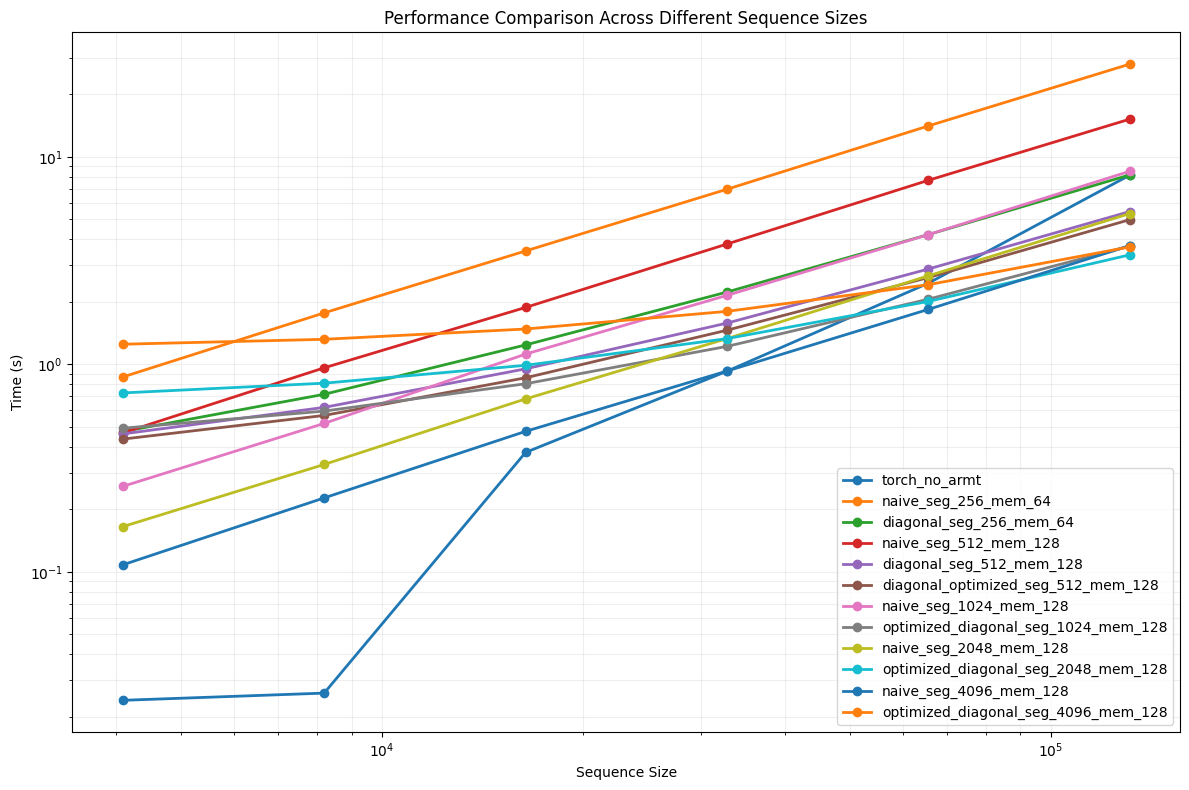

In [107]:
# Visualize the data
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))

# Plot all data columns except seq_size
for column in data.keys():
    if column != 'seq_size' and column != 'speedup':
        # Skip plotting columns with all None values
        if all(v is None for v in data[column]):
            continue
        plt.plot(data['seq_size'], data[column], marker='o', linewidth=2, label=column)

plt.xscale('log')  # Log scale for sequence size
plt.yscale('log')  # Log scale for time values

plt.xlabel('Sequence Size')
plt.ylabel('Time (s)')
plt.title('Performance Comparison Across Different Sequence Sizes')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('/home/jovyan/sivtsov/armt/graphs/llama1b_perf_comparison.pdf', bbox_inches='tight')
plt.show()

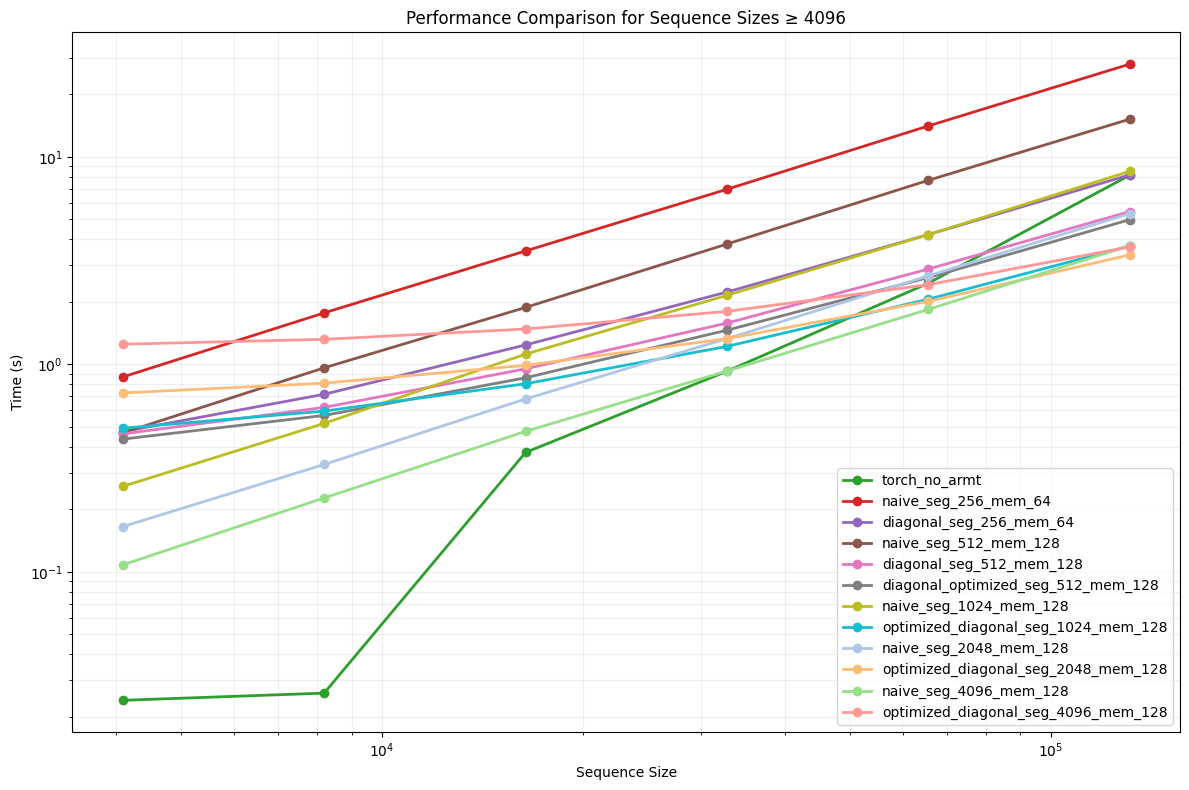

In [111]:
# Visualize the data
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))

# Define a colorful palette with more colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
          '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5',
          '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173',
          '#5254a3', '#bd9e39', '#ad494a', '#d6616b', '#7a0177']

# Filter data for sequence lengths >= 4096
min_seq_len = 4096
seq_indices = [i for i, size in enumerate(data['seq_size']) if size >= min_seq_len]
filtered_seq_size = [data['seq_size'][i] for i in seq_indices]

# Plot all data columns except seq_size
for i, column in enumerate(data.keys()):
    if column != 'seq_size' and column != 'speedup':
        # Skip plotting columns with all None values
        if all(v is None for v in data[column]):
            continue
        filtered_values = [data[column][i] for i in seq_indices]
        plt.plot(filtered_seq_size, filtered_values, marker='o', linewidth=2, 
                 label=column, color=colors[i % len(colors)])

plt.xscale('log')  # Log scale for sequence size
plt.yscale('log')  # Log scale for time values

plt.xlabel('Sequence Size')
plt.ylabel('Time (s)')
plt.title('Performance Comparison for Sequence Sizes ≥ 4096')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('/home/jovyan/sivtsov/armt/graphs/llama1b_perf_comparison_4096plus.pdf', bbox_inches='tight')
plt.show()


In [ ]:

# Create DataFrame
df = pd.DataFrame(data)

# Display the table
print("Parsed table:")
print(df)

# Plot the results
plt.figure(figsize=(12, 8))
plt.loglog(df['seq_size'], df['torch_naive'], 'o-', label='Torch Naive')
plt.loglog(df['seq_size'], df['diagonal'], 'o-', label='Diagonal')
plt.loglog(df['seq_size'][5:], df['torch_no_armt'][5:], 'o-', label='Torch No ARMT')
plt.xlabel('Sequence Size')
plt.ylabel('Time (s)')
plt.title('Performance Comparison')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

# Plot speedup
plt.figure(figsize=(12, 6))
plt.semilogx(df['seq_size'], df['speedup'], 'o-', label='Speedup (Torch Naive / Diagonal)')
plt.xlabel('Sequence Size')
plt.ylabel('Speedup Factor')
plt.title('Speedup of Diagonal Implementation vs Torch Naive')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()